
# **Introducción a Python para Análisis de Datos**
## Capítulo 7: Business Case - Solución
---
**Autor:** Juan Martin Bellido  

**Descripción**  
En este capítulo final pondremos en práctica conceptos adquiridos a lo largo del curso para resolver un caso práctico final. 

**¿Feedback? ¿comentarios?** Por favor compártelo conmigo escribiéndome por [LinkedIn](https://www.linkedin.com/in/jmartinbellido/)  


# Capítulo 7: Caso práctico
---

### Automatización de reporte

Como ejercicio final, crearemos un reporte automatizado.

* *Seleccionar una empresa que cotice en bolsa*
* *Extraer datos de cotizaciones diarias utilizando la API de Yahoo! Finance*
* *Construir gráfico de serie temporal que reporte media de cotización semanal para las últimas 8 semanas a fecha actual; reportar también el mismo período para el año anterior*
* *Generar un archivo PDF con el gráfico y exportarlo y una carpeta específica con el nombre de la empresa seleccionada*


In [ ]:
# instalamos si hace falta
pip install yfinance
pip install fpdf

In [9]:
# importamos librerías
import pandas as pd
import os
from matplotlib import pyplot as plt
from datetime import date
from datetime import timedelta
from fpdf import FPDF
import yfinance as yf

In [11]:
%matplotlib inline

In [12]:
# set-up
input_ticker = 'AMZN'

In [13]:
# creamos nuevo directorio
os.mkdir(input_ticker)

In [14]:
# componentes fecha
input_2YA = date.today() + timedelta(days=-365*2) # dos años atrás
input_yesterday = date.today() + timedelta(days=-1) # ayer

In [15]:
# extraemos datos
data = yf.download(input_ticker, start=input_2YA, end=input_yesterday)
data = data.reset_index()
data.dtypes

[*********************100%***********************]  1 of 1 completed


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [16]:
# creamos campos con componentes de fecha
data['year'] = data.Date.dt.year
data['week'] = data.Date.dt.isocalendar().week

In [17]:
# agregamos
df = data\
  .groupby(['year','week'])\
  .agg({'Open':'mean'})\
  .reset_index()\
  .rename(columns={'Open':'avg_rate'})

In [18]:
# creamos un nuevo campo
df['year_1YA'] = df['year'] - 1
df.head()

,year,week,avg_rate,year_1YA
0,2020,45,158.648700,2019
1,2020,46,156.697803,2019
2,2020,47,156.330701,2019
3,2020,48,157.129128,2019
4,2020,49,160.223001,2019


In [19]:
# manipulamos tabla
df_1 = df.tail(8).merge(
    df,
    how = 'left',
    left_on = ['year_1YA','week'],
    right_on = ['year','week']
).rename(
    columns = {'year_x':'year','avg_rate_x':'avg_rate','avg_rate_y':'avg_rate_1YA'}
).loc[:,['year','week','avg_rate','avg_rate_1YA']]

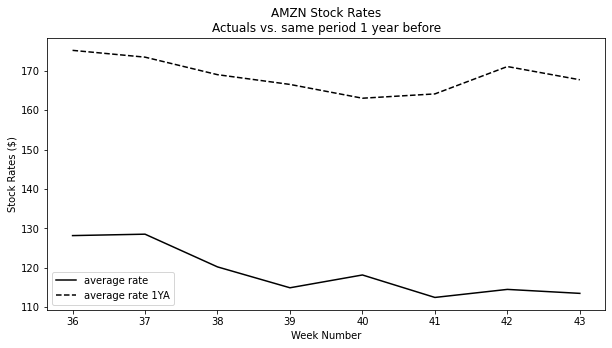

In [20]:
# paso 1: gráfico vacío
fig, ax = plt.subplots(figsize=(10,5))

# paso 2: gráficos de serie temporal
ax.plot(
    df_1['week'],
    df_1['avg_rate'],
    label = 'average rate',
    color = 'black'
)

ax.plot(
    df_1['week'],
    df_1['avg_rate_1YA'],
    label = 'average rate 1YA',
    color = 'black',
    linestyle = '--'
)

# paso 3: configuramos título y nombres de ejes 
ax.set(
    xlabel="Week Number",
    ylabel="Stock Rates ($)",
    title= input_ticker + " Stock Rates\nActuals vs. same period 1 year before"
)

ax.legend()

# exportamos
plt.savefig(input_ticker + '/my_chart.png', dpi=100)

In [21]:
# creamos un documento pdf vacío en memoria
my_pdf = FPDF()

# creamos una primer página en blanco
my_pdf.add_page()

# creamos un título
my_pdf.set_font(family='Arial', style='B', size=16) # we specify font
my_pdf.cell(w=0, h=10, txt=input_ticker + ' Stock Report', border = 1, align='C') # we include our first cell/container

# añadimos imagen con gráfico
image_location = input_ticker + '/my_chart.png'
my_pdf.image(image_location, x = 5, y = 40, w = 200, h = 0, type = '')

# exportamos documento
my_pdf.output(input_ticker + '_report.pdf')

''